# Inferring biological phases by clustering snapshots

Here, we infer biological phases of the cell cycle by clustering the snapshot of the temporal network.  
First, we compute a fixed number of clusters. Then, we compute a range of numbers of clusters, to explore a range of timescales. 

In [1]:
import string

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.metrics import adjusted_rand_score

import phasik as pk

sb.set_context("paper")

## 1. Build temporal network

In [2]:
# load static PPI network
static_net_filepath = "../data/kegg/static_PPI_network_KEGG.adjlist"
static_network = nx.read_adjlist(static_net_filepath)  # networkx Graph object

pk.graph_size_info(static_network)

# load edge time series
edge_activity_filepath = "../data/chen/edge_time_series_normed.csv"
# edge_activity_filepath = "data/chen/edge_time_series.csv"
norm = True

# use this for non-normalised time series
# edge_activity_filepath = "data/chen/edge_time_series.csv"
# norm = False

edge_series = pd.read_csv(edge_activity_filepath).transpose()
times = list(edge_series.columns)

# add noise
sigma = 0.5
noise = sigma * np.random.normal(scale=sigma, size=edge_series.shape)
edge_series_noisy = edge_series + noise
edge_series_noisy[edge_series_noisy < 0] = 0

edge_series.head()

0         1         2         3         4         5    \
BUB2-TEM1   1.000000  0.944640  0.821809  0.714192  0.616431  0.526373   
CDC14-CDH1  0.686659  1.000000  0.907541  0.820039  0.766979  0.705793   
CDC14-NET1  0.645917  0.671144  0.714681  0.731195  0.747004  0.768939   
CDC14-SIC1  0.018796  0.052740  0.205271  0.506905  0.762640  0.932310   
CDC14-SWI5  0.979236  1.000000  0.774786  0.653575  0.569462  0.487680   

                 6         7         8         9    ...       92        93   \
BUB2-TEM1   0.443475  0.367971  0.300570  0.242267  ...  1.000000  1.000000   
CDC14-CDH1  0.627266  0.531560  0.427561  0.325439  ...  0.001641  0.002252   
CDC14-NET1  0.796495  0.825434  0.855900  0.876039  ...  0.994226  0.988840   
CDC14-SIC1  1.000000  0.961426  0.844510  0.683152  ...  0.000500  0.000602   
CDC14-SWI5  0.403337  0.318311  0.238636  0.169497  ...  0.110348  0.127783   

                 94        95        96        97        98        99   \
BUB2-TEM1   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
CDC14-CDH1  0.003354  0.005618  0.010949  0.024823  0.061775  0.150247   
CDC14-NET1  0.977254  0.962266  0.933738  0.890852  0.830224  0.766072   
CDC14-SIC1  0.000754  0.000999  0.001407  0.002092  0.003217  0.005076   
CDC14-SWI5  0.153343  0.193334  0.256378  0.352987  0.486287  0.645238   

                 100       101  
BUB2-TEM1   1.000000  1.000000  
CDC14-CDH1  0.325150  0.609259  
CDC14-NET1  0.706295  0.655787  
CDC14-SIC1  0.008461  0.016047  
CDC14-SWI5  0.807102  0.951225  

[5 rows x 102 columns]

In [3]:
# build temporal network

# this function buils a TemporalNetwork, by integrating the edge time series to the static network,
# and setting a constant default weight value for edges for which we have no temporal information
temporal_network = pk.TemporalNetwork.from_static_network_and_edge_timeseries(
    static_network,
    edge_series,
    static_edge_default_weight=1,
    quiet=True,  # if True, prints less information
)

temporal_network_name = f"kegg_chen_normed_{norm}"

A PartiallyTemporalNetwork is created instead.


In [4]:
# build temporal network

# this function buils a TemporalNetwork, by integrating the edge time series to the static network,
# and setting a constant default weight value for edges for which we have no temporal information
temporal_network_noisy = pk.TemporalNetwork.from_static_network_and_edge_timeseries(
    static_network,
    edge_series_noisy,
    static_edge_default_weight=1,
    quiet=True,  # if True, prints less information
)

temporal_network_name = f"kegg_chen_normed_noisy_{norm}"

A PartiallyTemporalNetwork is created instead.


In [5]:
print(f"Temporal network shape (N, T): {temporal_network.shape()}")
print(pk.graph_size_info(static_network))
print(f"Number of temporal edges: {len(temporal_network.temporal_edges)}")

Temporal network shape (N, T): (83, 102)
83 nodes and 159 edges
Number of temporal edges: 34


## 2. Infer biological phases with hierarchical clustering

In [6]:
# clustering parameters
distance_metric = "euclidean"  # used to compute distance between snapshots
clustering_method = "ward"  # clustering method
n_max_type = "maxclust"  # set number of clusters by maximum number of clusters wanted

n_max = 5  # max number of clusters
n_max_range = range(2, 12)  # range of numbers of clusters to compute

# plotting parameters
if norm:
    output_directory = "images/chen/normalised/"
else:
    output_directory = "images/chen/"

events_times = [5, 33, 36, 70, 84, 100]
events_labels = ["START", "bud", "ori", "E3", "spn", "mass"]
events = [(time, name, "dashed") for time, name in zip(events_times, events_labels)]

phases = [(0, 35, "G1"), (35, 70, "S"), (70, 78, "G2"), (78, 100, "M")]

time_ticks = range(101, 10)
# variables_to_plot = []

### 2.1 Single number of clusters

In [7]:
distance_matrix = pk.DistanceMatrix.from_temporal_network(
    temporal_network, distance_metric
)
# single number of cluster
cluster_set = pk.ClusterSet.from_distance_matrix(
    distance_matrix, n_max_type, n_max, clustering_method
)

/var/folders/w7/qwjxv8yd74s3mjqdnnykkqbc0000gp/T/ipykernel_90099/1905890261.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(range(0, 101, 20))


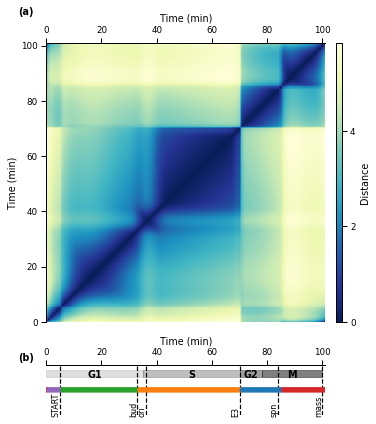

In [8]:
# plot clusters

gs_kw = dict(width_ratios=[1], height_ratios=[6, 1])

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw=gs_kw, sharex=True, figsize=(5, 7))

# distance matrix
im = ax1.imshow(
    distance_matrix.distance_matrix,
    aspect="equal",
    origin="lower",
    cmap="YlGnBu_r",
)
# sb.despine(ax=ax1)
sb.despine(ax=ax1, top=False, bottom=True)

ax1.set_ylim(0, 101)
ax1.set_ylabel("Time (min)")
ax1.set_xlabel("Time (min)")
ax1.xaxis.set_label_position("top")
ax1.xaxis.set_ticks_position("top")
# ax1.set_title(f"Distance matrix with {distance_metric} distance", weight="bold")
# plot_events(events, ax=ax1, orientation="vertical", zorder=2, alpha=0.5, add_labels=False)
# plot_events(events, ax=ax1, orientation="horizontal", zorder=2, alpha=0.5, add_labels=False)

# clusters
cluster_set.plot(ax=ax2, colors=[4, 5, 3, 2, 1], y_height=0)
# cluster_set.plot(ax=ax2, colours=None)

sb.despine(ax=ax2, left=True, bottom=True, top=False)
# only way to get rid of spine offset in scatter plot apparently
ax2.set_xlim(0, 101)
ax2.set_yticks([])
ax2.set_xlabel("Time (min)")
ax2.set_xticklabels(range(0, 101, 20))
# ax2.set_title(f"{cluster_set.size} clusters", weight="bold")
ax2.xaxis.set_label_position("top")

pk.plot_phases(phases, ax=ax2, y_pos=0.8, ymax=0.9, ymin=0.75)
pk.plot_events(events, ax=ax2, text_y_pos=-0.06, text_x_offset=1.5)


# plt.subplots_adjust(hspace=-0.1)

# colorbar
cax = fig.add_axes((0, 0, 1, 0.1))
pos1 = ax1.get_position()  # get the original position
pos2 = [
    pos1.x0 + pos1.width + 0.03,
    pos1.y0,
    pos1.width * 0.02,
    pos1.height,
]  # vertical
cax.set_position(pos2)  # set a new position

cb = fig.colorbar(im, cax=cax)
cb.set_ticks([0, 2, 4])
cb.set_label("Distance")
sb.despine(ax=cax)

# label subplots
for n, ax in enumerate([ax1, ax2]):
    ax.text(
        -0.1,
        1.1,
        f"({string.ascii_lowercase[n]})",
        transform=ax.transAxes,
        size="medium",
        weight="bold",
    )

# Save
if output_directory is not None:
    filename = f"distmat_{cluster_set.n_clusters}_clusters_method_{clustering_method}_dist_{distance_metric}_{temporal_network_name}"
#     plt.savefig(f"{filename}_rev.png", dpi=250, bbox_inches="tight")
#     plt.savefig(f"{filename}_rev.svg", dpi=250, bbox_inches="tight")

plt.show()

In [9]:
distance_matrix_noisy = pk.DistanceMatrix.from_temporal_network(
    temporal_network_noisy, distance_metric
)
# single number of cluster
cluster_set_noisy = pk.ClusterSet.from_distance_matrix(
    distance_matrix_noisy, n_max_type, n_max, clustering_method
)

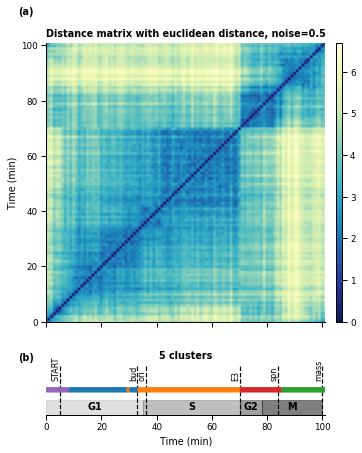

In [10]:
# plot clusters
# drawing.configure_sch_color_map(cm.get_cmap('tab10'))
# palette = drawing.palette_20_ordered()
# sb.set_palette(palette)

gs_kw = dict(width_ratios=[1], height_ratios=[6, 1])

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw=gs_kw, sharex=True, figsize=(5, 7))

# distance matrix
im = ax1.imshow(
    distance_matrix_noisy.distance_matrix,
    aspect="equal",
    origin="lower",
    cmap="YlGnBu_r",
)
sb.despine(ax=ax1)
ax1.set_ylim(0, 101)
ax1.set_ylabel("Time (min)")
ax1.set_title(
    f"Distance matrix with {distance_metric} distance, noise={sigma}",
    weight="bold",
)


# clusters
cluster_set_noisy.plot(ax=ax2)
# cluster_set_noisy.plot(ax=ax2, colours=[4, 5, 3, 2, 1])
# cluster_set.plot(ax=ax2, colours=None)

sb.despine(ax=ax2, left=True)
# only way to get rid of spine offset in scatter plot apparently
ax2.set_xlim(0, 101)
ax2.set_yticks([])
ax2.set_xlabel("Time (min)")
ax2.set_title(f"{cluster_set.n_clusters} clusters", weight="bold")

pk.plot_phases(phases, ax=ax2, y_pos=0.15, ymax=0.3)
pk.plot_events(events, ax=ax2, text_y_pos=0.02, text_x_offset=1.5)


# plt.subplots_adjust(hspace=-0.1)

# colorbar
cax = fig.add_axes((0, 0, 1, 0.1))
pos1 = ax1.get_position()  # get the original position
pos2 = [
    pos1.x0 + pos1.width + 0.03,
    pos1.y0,
    pos1.width * 0.02,
    pos1.height,
]  # vertical
cax.set_position(pos2)  # set a new position

fig.colorbar(im, cax=cax)
sb.despine(ax=cax)

# label subplots
for n, ax in enumerate([ax1, ax2]):
    ax.text(
        -0.1,
        1.1,
        f"({string.ascii_lowercase[n]})",
        transform=ax.transAxes,
        size="medium",
        weight="bold",
    )

# Save
if output_directory is not None:
    filename = f"distmat_noise_{sigma}_{cluster_set.n_clusters}_clusters_method_{clustering_method}_dist_{distance_metric}_{temporal_network_name}"
    # plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
    # plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

plt.show()

### 2.2 Range of number of clusters: exploring timescales

In [11]:
# range of numbers of clusters
cluster_sets = pk.ClusterSets.from_distance_matrix(
    distance_matrix, n_max_type, n_max_range, clustering_method
)

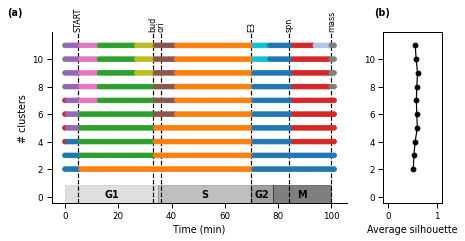

In [12]:
# Plot
gridspec_kw = {"width_ratios": [5, 1]}
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(7, 3.5), gridspec_kw=gridspec_kw, sharey="all"
)

cluster_sets.plot(axs=(ax1, ax2), with_silhouettes=True)
pk.adjust_margin(ax=ax1, bottom=0.2 if phases else 0.05, top=0.05)
pk.plot_events(events, ax=ax1)
pk.plot_phases(phases, ax=ax1, y_pos=0.05, ymax=0.1)

# Format
ax1.set_xlabel("Time (min)")
ax1.set_axisbelow(True)
# ax1.set_ylabel(drawing.display_name(cluster_sets.limit_type))
ax1.set_ylabel("# clusters")

if time_ticks:
    ax1.set_xticks(time_ticks)
sb.despine(ax=ax1)

ax2.set_xlabel("Average silhouette")
ax2.set_xlim((-0.1, 1.1))
# ax2.set_xlim((0.5, 0.61))
ax2.yaxis.set_tick_params(labelleft=True)


plt.subplots_adjust(wspace=0.2, top=0.8)
# title = f'Clusters and silhouette scores (no thresholding)\n{temporal_network_name}'
# fig.suptitle(title)

# label subplots
for n, ax in enumerate([ax1, ax2]):
    ax.text(
        -0.15,
        1.1,
        f"({string.ascii_lowercase[n]})",
        transform=ax.transAxes,
        size="medium",
        weight="bold",
    )

# Save
if output_directory is not None:
    pass
    filename = f"phase_clusters_all_clusters_method_{clustering_method}_dist_{distance_metric}_{temporal_network_name}"
#     plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
#     plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

In [13]:
# range of numbers of clusters
cluster_sets_noisy = pk.ClusterSets.from_distance_matrix(
    distance_matrix_noisy, n_max_type, n_max_range, clustering_method
)

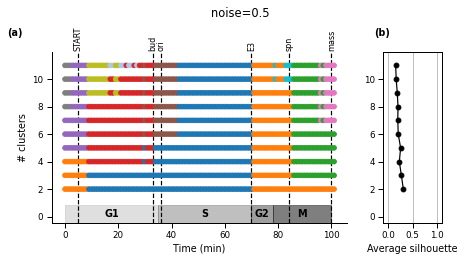

In [14]:
# Plot
gridspec_kw = {"width_ratios": [5, 1]}
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(7, 3.5), gridspec_kw=gridspec_kw, sharey="all"
)

cluster_sets_noisy.plot(axs=(ax1, ax2), with_silhouettes=True)
pk.adjust_margin(ax=ax1, bottom=0.2 if phases else 0.05, top=0.05)
pk.plot_events(events, ax=ax1)
pk.plot_phases(phases, ax=ax1, y_pos=0.05, ymax=0.1)

# Format
ax1.set_xlabel("Time (min)")
ax1.set_axisbelow(True)
# ax1.set_ylabel(drawing.display_name(cluster_sets.limit_type))
ax1.set_ylabel("# clusters")

if time_ticks:
    ax1.set_xticks(time_ticks)
sb.despine(ax=ax1)

ax2.set_xlabel("Average silhouette")
ax2.set_xlim((-0.1, 1.1))
# ax2.set_xlim((0.5, 0.61))
ax2.yaxis.set_tick_params(labelleft=True)
ax2.set_xticks([0, 0.5, 1])
ax2.grid(axis="x")


plt.subplots_adjust(wspace=0.2, top=0.8)
# title = f'Clusters and silhouette scores (no thresholding)\n{temporal_network_name}'
fig.suptitle(f"noise={sigma}")

# label subplots
for n, ax in enumerate([ax1, ax2]):
    ax.text(
        -0.15,
        1.1,
        f"({string.ascii_lowercase[n]})",
        transform=ax.transAxes,
        size="medium",
        weight="bold",
    )

# Save
if output_directory is not None:
    pass
    filename = f"/phase_clusters_all_clusters_method_noise_{sigma}_{clustering_method}_dist_{distance_metric}_{temporal_network_name}"
    # plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
    # plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

## Comparing 5 clusters quantitatively

In [15]:
valid_sets = []

# compute reference clusters
distance_matrix = pk.DistanceMatrix.from_temporal_network(
    temporal_network, distance_metric
)
# single number of cluster
cluster_set = pk.ClusterSet.from_distance_matrix(
    distance_matrix, n_max_type, n_max, clustering_method
)

# compute modified clusters
sigmas = np.arange(0, 0.55, 0.1)

for i, sigma in enumerate(sigmas):

    #     sigma = 0.4
    noise = sigma * np.random.normal(scale=sigma, size=edge_series.shape)
    edge_series_noisy = edge_series + noise
    edge_series_noisy[edge_series_noisy < 0] = 0

    temporal_network_noisy = pk.TemporalNetwork.from_static_network_and_edge_timeseries(
        static_network,
        edge_series_noisy,
        static_edge_default_weight=1,
        quiet=True,  # if True, prints less information
    )

    # compute clusters
    distance_matrix_noisy = pk.DistanceMatrix.from_temporal_network(
        temporal_network_noisy, distance_metric
    )
    # single number of cluster
    cluster_set_noisy = pk.ClusterSet.from_distance_matrix(
        distance_matrix_noisy, n_max_type, n_max, clustering_method
    )

    #     rand_index = adjusted_rand_score(cluster_set.clusters, cluster_set_downsampled.clusters)

    #     valid_sets.append([snapshots_downsampled, cluster_set_downsampled, skip, rand_index])
    valid_sets.append([distance_matrix_noisy, cluster_set_noisy, sigma])

A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.


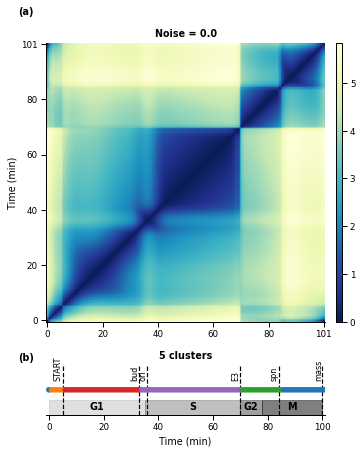

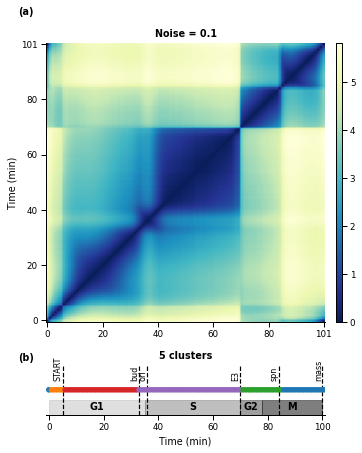

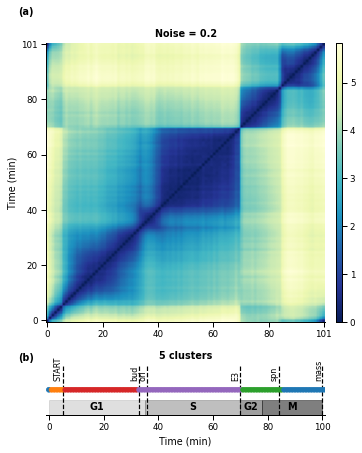

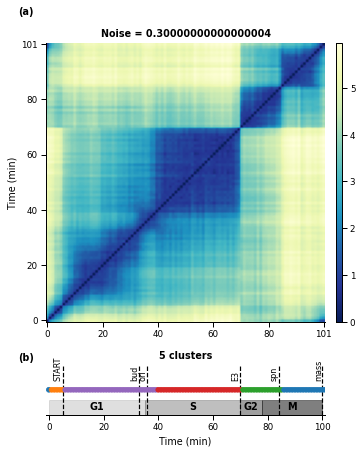

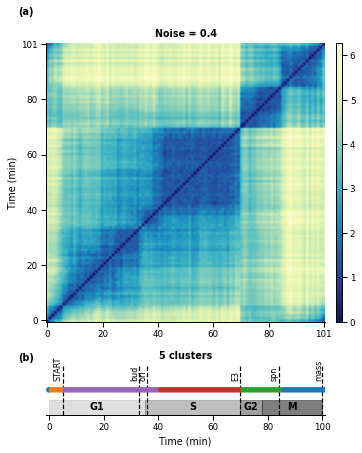

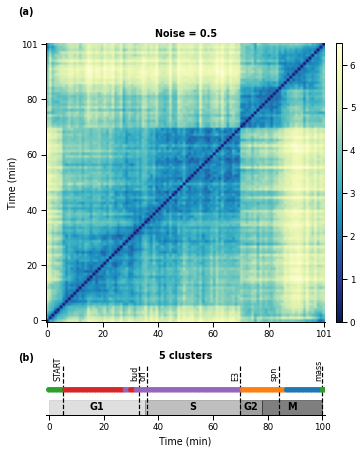

In [16]:
for i, (distance_matrix_modified, cluster_set_modified, node) in enumerate(valid_sets):

    sigma = sigmas[i]
    times_modified = distance_matrix_modified.times
    n_times = len(times_modified)
    # plot clusters
    pk.configure_sch_color_map(cm.get_cmap("tab10"))
    sb.set_palette("Dark2", n_colors=8)

    gs_kw = dict(width_ratios=[1], height_ratios=[6, 1])

    fig, (ax1, ax2) = plt.subplots(
        2, 1, gridspec_kw=gs_kw, sharex=False, figsize=(5, 7)
    )

    # distance matrix
    im = ax1.imshow(
        distance_matrix_modified.distance_matrix,
        aspect="equal",
        origin="lower",
        cmap="YlGnBu_r",
    )

    n_ticks = 6
    ticks = np.linspace(0, n_times - 1, num=n_ticks)
    tick_labels = np.linspace(
        times_modified[0], times_modified[-1], num=n_ticks, dtype=int
    )
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)
    ax1.set_xticklabels(tick_labels)
    ax1.set_yticklabels(tick_labels)

    sb.despine(ax=ax1)
    #     ax1.set_ylim(0, 101)
    ax1.set_ylabel("Time (min)")
    #     ax1.set_title(f"Distance matrix with {distance_metric} distance", weight="bold")
    ax1.set_title(f"Noise = {sigma}", weight="bold")

    # clusters
    cluster_set_modified.plot(ax=ax2)

    sb.despine(ax=ax2, left=True)
    # only way to get rid of spine offset in scatter plot apparently
    ax2.set_xlim(-1, 101)
    ax2.set_yticks([])
    ax2.set_xlabel("Time (min)")
    ax2.set_title(f"{cluster_set_modified.n_clusters} clusters", weight="bold")

    pk.plot_phases(phases, ax=ax2, y_pos=0.15, ymax=0.3)
    pk.plot_events(events, ax=ax2, text_y_pos=0.02, text_x_offset=1.5)

    # plt.subplots_adjust(hspace=-0.1)

    # colorbar
    cax = fig.add_axes((0, 0, 1, 0.1))
    pos1 = ax1.get_position()  # get the original position
    pos2 = [
        pos1.x0 + pos1.width + 0.03,
        pos1.y0,
        pos1.width * 0.02,
        pos1.height,
    ]  # vertical
    cax.set_position(pos2)  # set a new position

    fig.colorbar(im, cax=cax)
    sb.despine(ax=cax)

    # label subplots
    for n, ax in enumerate([ax1, ax2]):
        ax.text(
            -0.1,
            1.1,
            f"({string.ascii_lowercase[n]})",
            transform=ax.transAxes,
            size="medium",
            weight="bold",
        )

    # Save
    if output_directory is not None:
        filename = f"distmat_{cluster_set.n_clusters}_noise_{noise}_clusters_method_{clustering_method}_dist_{distance_metric}_{temporal_network_name}"
    #         plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
    #         plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")
    #         pass

    plt.show()

In [18]:
def rand_index_over_noises(valid_cluster_sets, reference_noise=0):
    """
    Compute Rand Index to compare any method to a reference method, for all combinations of methods and number of clusters


    Parameters
    ----------
    valid_cluster_sets : list

    reference_method : str

    Returns
    -------

    rand_scores : ndarray
        Array of dimension (n_sizes, n_methods) with rand index scores

    """

    valid_noises = [sets[2] for sets in valid_cluster_sets]

    i_ref = valid_noises.index(reference_noise)
    clusters_ref = valid_cluster_sets[i_ref][1]

    # compute Rand index to compare each method with reference method
    n_noises = len(valid_cluster_sets)

    rand_scores = np.zeros((n_noises))

    for i_noise, noise in enumerate(valid_noises):

        clusters2 = valid_cluster_sets[i_noise][1]

        rand_index = adjusted_rand_score(clusters_ref.clusters, clusters2.clusters)
        rand_scores[i_noise] = rand_index

    return rand_scores

In [19]:
rand_idx = rand_index_over_noises(valid_sets)
rand_idx

array([1.        , 0.96707525, 0.96707525, 0.81657131, 0.78984354,
       0.83147897])

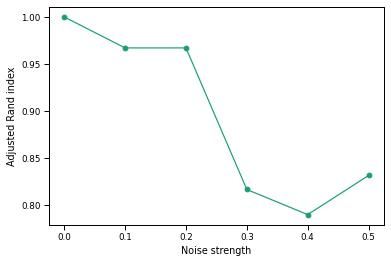

In [20]:
fig, ax = plt.subplots()

ax.plot(sigmas, rand_idx, "o-")

ax.set_ylabel("Adjusted Rand index")
ax.set_xlabel("Noise strength")


# Save
if output_directory is not None:
    #     pass
    filename = f"5_clusters_rand_noise_{sigmas[::2]}_{clustering_method}_dist_{distance_metric}_{temporal_network_name}"
#     plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
#     plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

plt.show()

### Multiple noise repetitions

In [21]:
valid_sets = []

n_max = 10

# compute reference clusters
distance_matrix = pk.DistanceMatrix.from_temporal_network(
    temporal_network, distance_metric
)
# single number of cluster
cluster_set = pk.ClusterSet.from_distance_matrix(
    distance_matrix, n_max_type, n_max, clustering_method
)

# compute modified clusters
sigmas = np.arange(0, 1.05, 0.05)
n_reps = 10  # number of noise realisations

for i, sigma in enumerate(sigmas):

    print("============================")
    print("================", sigma)
    print("============================")

    valid_sets.append([[], [], sigma])

    #     sigma = 0.4
    for j in range(n_reps):

        noise = sigma * np.random.normal(scale=sigma, size=edge_series.shape)
        edge_series_noisy = edge_series + noise
        edge_series_noisy[edge_series_noisy < 0] = 0

        temporal_network_noisy = (
            pk.TemporalNetwork.from_static_network_and_edge_timeseries(
                static_network,
                edge_series_noisy,
                static_edge_default_weight=1,
                quiet=True,  # if True, prints less information
            )
        )

        # compute clusters
        distance_matrix_noisy = pk.DistanceMatrix.from_temporal_network(
            temporal_network_noisy, distance_metric
        )
        # single number of cluster
        cluster_set_noisy = pk.ClusterSet.from_distance_matrix(
            distance_matrix_noisy, n_max_type, n_max, clustering_method
        )

        #     rand_index = adjusted_rand_score(cluster_set.clusters, cluster_set_downsampled.clusters)

        #     valid_sets.append([snapshots_downsampled, cluster_set_downsampled, skip, rand_index])
        #     valid_sets.append([snapshots_noisy, cluster_set_noisy, sigma])
        valid_sets[-1][0].append(distance_matrix_noisy)
        valid_sets[-1][1].append(cluster_set_noisy)

================ 0.0
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
================ 0.05
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
================ 

A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
================ 0.35000000000000003
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
================ 0.4
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A 

A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
================ 0.65
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
================ 0.7000000000000001
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A 

A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
================ 0.9500000000000001
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
================ 1.0
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A PartiallyTemporalNetwork is created instead.
A P

In [22]:
def rand_index_over_noises_reps(valid_cluster_sets, reference_noise=0):
    """
    Compute Rand Index to compare any method to a reference method, for all combinations of methods and number of clusters


    Parameters
    ----------
    valid_cluster_sets : list
        Each element is structured as [list_of_snapshots, list_of_cluster_sets, sigma]

    reference_method : str

    Returns
    -------

    rand_scores : ndarray
        Array of dimension (n_sizes, n_methods) with rand index scores

    """

    valid_noises = [sets[2] for sets in valid_cluster_sets]
    n_reps = len(valid_cluster_sets[0][1])

    i_ref = valid_noises.index(reference_noise)
    clusters_ref = valid_cluster_sets[i_ref][1][0]
    # compute Rand index to compare each method with reference method
    n_noises = len(valid_cluster_sets)

    rand_scores = np.zeros((n_noises, n_reps))

    for i_noise, noise in enumerate(valid_noises):
        for j in range(n_reps):

            clusters2 = valid_cluster_sets[i_noise][1][j]

            rand_index = adjusted_rand_score(clusters_ref.clusters, clusters2.clusters)
            rand_scores[i_noise, j] = rand_index

    return rand_scores

In [23]:
rand_idx_arr = rand_index_over_noises_reps(valid_sets)
# rand_idx_arr

rand_filename = f"../data/kegg/rand_idx_array_noise_{n_max}_clusters_nreps_{n_reps}_sigmas_{sigmas}.npy"
np.save(rand_filename, rand_idx_arr)

In [24]:
rand_idx_avg = np.mean(rand_idx_arr, axis=1)
std_error = np.std(rand_idx_arr, axis=1) / np.sqrt(n_reps)

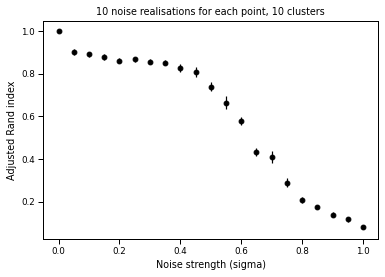

In [25]:
fig, ax = plt.subplots()

# ax.plot(sigmas, rand_idx_avg, 'o-')

ax.errorbar(sigmas, rand_idx_avg, yerr=std_error, fmt="ok")


ax.set_ylabel("Adjusted Rand index")
ax.set_xlabel("Noise strength (sigma)")

ax.set_title(f"{n_reps} noise realisations for each point, {n_max} clusters")

# Save
if output_directory is not None:
    #     pass
    filename = f"{n_max}_clusters_rand_noise_{sigmas[::2]}_n_reps_{n_reps}_{clustering_method}_dist_{distance_metric}_{temporal_network_name}"
#     plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
#     plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

plt.show()

In [27]:
# plot multiple cluster numbers
and_filename = (
    f"../data/kegg/rand_idx_array_noise_2_clusters_nreps_{n_reps}_sigmas_{sigmas}.npy"
)
rand_idx_arr_2 = np.load(rand_filename)
rand_idx_avg_2 = np.mean(rand_idx_arr_2, axis=1)
std_error_2 = np.std(rand_idx_arr_2, axis=1) / np.sqrt(n_reps)

rand_filename = (
    f"../data/kegg/rand_idx_array_noise_5_clusters_nreps_{n_reps}_sigmas_{sigmas}.npy"
)
rand_idx_arr_5 = np.load(rand_filename)
rand_idx_avg_5 = np.mean(rand_idx_arr_5, axis=1)
std_error_5 = np.std(rand_idx_arr_5, axis=1) / np.sqrt(n_reps)

rand_filename = (
    f"../data/kegg/rand_idx_array_noise_10_clusters_nreps_{n_reps}_sigmas_{sigmas}.npy"
)
rand_idx_arr_10 = np.load(rand_filename)
rand_idx_avg_10 = np.mean(rand_idx_arr_10, axis=1)
std_error_10 = np.std(rand_idx_arr_10, axis=1) / np.sqrt(n_reps)

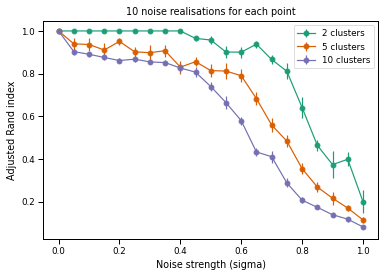

In [30]:
fig, ax = plt.subplots()

ax.errorbar(sigmas, rand_idx_avg_2, yerr=std_error_2, fmt="o-", label=f"2 clusters")
ax.errorbar(sigmas, rand_idx_avg_5, yerr=std_error_5, fmt="o-", label=f"5 clusters")
ax.errorbar(sigmas, rand_idx_avg_10, yerr=std_error_10, fmt="o-", label=f"10 clusters")

ax.set_ylabel("Adjusted Rand index")
ax.set_xlabel("Noise strength (sigma)")

ax.set_title(f"{n_reps} noise realisations for each point")

ax.legend()

# Save
if output_directory is not None:
    #     pass
    filename = f"2_5_10_clusters_rand_noise_{sigmas[::2]}_n_reps_{n_reps}_{clustering_method}_dist_{distance_metric}_{temporal_network_name}"
#     plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
#     plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

plt.show()